# CS230 Project
# Deep Learning for VQA: Visual Question Answering

Stephanie Do <br> Alona King <br> Jennifer Villa

## Introduction

Our project explores the challenge of visual question answering (VQA) -- given an image and an open ended question concerning the image, build a model that returns a correct answer. This topic requires synthesizing both visual and language modalities, and combining the two to produce a natural language answer, making it more challenging than traditional image classification. VQA challenges researchers to create networks with a more sophisticated level of understanding that could ultimately be used to help robots or drones navigate their environment. These networks could also give visually impaired people a more rich description of a scene, or be used for better image or product search within a database.


## Dataset Description
For this project, we will be using the VQA v2.0 dataset. Unlike VQA 1.0, which included both real and abstract scenes, VQA 2.0 only looks at real images. The task is also slightly different between versions - v1.0 included both open ended and multiple choice question answering, whereas v2.0 focuses exclusively on open ended question answering. 

<br> The VQA 2.0 dataset is a collection of 82,783 MS COCO training images, 40,504 MS COCO validation images and 81,434 MS COCO testing images. Each image has 3+ associated questions, for a total of 443,757 questions for training, 214,354 questions for validation and 447,793 questions for testing. Each question is associated with 10 ground truth answers, corresponding to the answers of 10 different human respondents when asked given the image-question pair. The dataset also includes a field identifying the most frequent ground truth answer of this set. <br>

<br> Questions are broken into 3 sub-groups, based on their answer types: "yes/no", "number", and "other." The VQA challenge reports model accuracy for each sub-group, as well as an overall number. 

Examples from the VQA v2.0 dataset <br>
Question: What color is the hydrant? <br> <img src="FireHydrant.png"> <br> Answer: Red



Question:  What is hanging above the toilet? <br> <img src="TeddyBear.png"> <br>  Answer: teddy bear

<br> VQA 2.0 also includes a "complementary pairs" dataset. These are pairs of images that share the same question, but the answer to that question is different for each image (see below for example). Some [research](https://arxiv.org/pdf/1612.00837.pdf) has shown that training with this dataset improves model accuracy and prevents the model from overfitting to the most common answers. As of now, we are not using this dataset, but we may investigate using it as an extension.  <img src="PairedImages.png"> 

## Evaluation Metric

The VQA Challenge has set up its own evaluation platform using EvalAI. The metric used for the challenge is <br> <br>
$Acc(ans) = min \{ \frac{\text{num humans that said ans} }{3}, 1 \} $
<br> The metric accounts for the fact that human respondents might give slightly different answers for a question. When asked "what color is the scarf?", one set of respondents might say "blue", while another set might say "purple." If at least 3 of the 10 respondents give a particular answer, the answer is considered a full credit answer. Otherwise, fractional credit is awarded based on the number of people who gave that answer. 


## First Steps -- Initial VQA Model

As of now, we have loaded and run the original VQA model described in this [paper](https://arxiv.org/pdf/1505.00468.pdf). The model (which can be found [here](https://github.com/anantzoid/VQA-Keras-Visual-Question-Answering)) is implemented in Keras with a Tensorflow backend. 
<br><br> 
We begin with all necessary import statements. Please note that you need Keras, Tensorflow, and h5py installed to run this code. 


In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, Flatten, Embedding, Merge, Input, Multiply, Concatenate, Lambda
from keras.layers.merge import Multiply
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
import h5py

Using TensorFlow backend.


### Download the Dataset
We begin with the dataset described above. You will need to download the following: <br>
1. [GloVe Embeddings](http://nlp.stanford.edu/data/glove.6B.zip)
2. [Training Data](https://filebox.ece.vt.edu/~jiasenlu/codeRelease/vqaRelease/train_only/data_train_val.zip)
3. [Validation Data](http://visualqa.org/data/mscoco/vqa/Annotations_Val_mscoco.zip)
4. [Pre-trained Model Weights](https://drive.google.com/file/d/0B3b69xdtpDT8U2dwajNKOEhUWUU/view?usp=sharing)

Having downloaded these files, create a `data` directory within the same directory you are running this notebook. Extract these zip files into this data directory so that you have the following files/directories in `data`:
1. data_img.h5
2. data_prepro.h5
3. dada_prepro.json
4. glove.6B.300d.txt
5. Questions_Train_mscoco/MultipleChoice_mscoco_train2014_questions.json
6. validation_data/mscoco_val2014_annotations.json
7. model_weights.h5

Having set up the data, we now set the following constants relating to our dataset:

In [14]:
seq_length =    26
embedding_dim = 300

data_img =                  'data/data_img.h5'
data_prepo =                'data/data_prepro.h5'
data_prepo_meta =           'data/data_prepro.json'
embedding_matrix_filename = 'data/ckpts/embeddings_%s.h5'%embedding_dim
glove_path =                'data/glove.6B.300d.txt'
train_questions_path =      'data/Questions_Train_mscoco/MultipleChoice_mscoco_train2014_questions.json'
val_annotations_path =      'data/validation_data/mscoco_val2014_annotations.json'
ckpt_model_weights_filename =    'data/ckpts/trained_model_weights.h5'

Next, we load the functions for preprocessing the data. These were functions taken from the published model, with a few tweaks (fixed 1-2 small bugs and broken paths; fixes for python 3 instead of python 2 usage). 

In [15]:
import numpy as np
from keras.utils.np_utils import to_categorical
import json
import h5py
import os

def right_align(seq,lengths):
    v = np.zeros(np.shape(seq))
    N = np.shape(seq)[1]
    for i in range(np.shape(seq)[0]):
        v[i][N-lengths[i]:N]=seq[i][0:lengths[i]]
    return v

def read_data(data_limit):
    print("Reading Data...")
    img_data = h5py.File(data_img)
    ques_data = h5py.File(data_prepo)
  
    img_data = np.array(img_data['images_train'])
    img_pos_train = ques_data['img_pos_train'][:data_limit]
    train_img_data = np.array([img_data[_-1,:] for _ in img_pos_train])
    # Normalizing images
    tem = np.sqrt(np.sum(np.multiply(train_img_data, train_img_data), axis=1))
    train_img_data = np.divide(train_img_data, np.transpose(np.tile(tem,(4096,1))))

    #shifting padding to left side
    ques_train = np.array(ques_data['ques_train'])[:data_limit, :]
    ques_length_train = np.array(ques_data['ques_length_train'])[:data_limit]
    ques_train = right_align(ques_train, ques_length_train)

    train_X = [train_img_data, ques_train]
    # NOTE should've consturcted one-hots using exhausitve list of answers, cause some answers may not be in dataset
    # To temporarily rectify this, all those answer indices is set to 1 in validation set
    train_y = to_categorical(ques_data['answers'])[:data_limit, :]

    return train_X, train_y

def get_val_data():
    img_data = h5py.File(data_img)
    ques_data = h5py.File(data_prepo)
    metadata = get_metadata()
    with open(val_annotations_path, 'r') as an_file:
        annotations = json.loads(an_file.read())

    img_data = np.array(img_data['images_test'])
    img_pos_train = ques_data['img_pos_test']
    train_img_data = np.array([img_data[_-1,:] for _ in img_pos_train])
    tem = np.sqrt(np.sum(np.multiply(train_img_data, train_img_data), axis=1))
    train_img_data = np.divide(train_img_data, np.transpose(np.tile(tem,(4096,1))))

    ques_train = np.array(ques_data['ques_test'])
    ques_length_train = np.array(ques_data['ques_length_test'])
    ques_train = right_align(ques_train, ques_length_train)

    # Convert all last index to 0, coz embeddings were made that way :/
    for _ in ques_train:
        if 12602 in _:
            _[_==12602] = 0

    val_X = [train_img_data, ques_train]

    ans_to_ix = {str(ans):int(i) for i,ans in metadata['ix_to_ans'].items()}
    ques_annotations = {}
    for _ in annotations['annotations']:
        idx = ans_to_ix.get(_['multiple_choice_answer'].lower())
        _['multiple_choice_answer_idx'] = 1 if idx in [None, 1000] else idx
        ques_annotations[_['question_id']] = _

    abs_val_y = [ques_annotations[ques_id]['multiple_choice_answer_idx'] for ques_id in ques_data['question_id_test']]
    abs_val_y = to_categorical(np.array(abs_val_y))

    multi_val_y = [list(set([ans_to_ix.get(_['answer'].lower()) for _ in ques_annotations[ques_id]['answers']])) for ques_id in ques_data['question_id_test']]
    for i,_ in enumerate(multi_val_y):
        multi_val_y[i] = [1 if ans in [None, 1000] else ans for ans in _]

    return val_X, abs_val_y, multi_val_y


def get_metadata():
    meta_data = json.load(open(data_prepo_meta, 'r'))
    meta_data['ix_to_word'] = {str(word):int(i) for i,word in meta_data['ix_to_word'].items()}
    return meta_data

def prepare_embeddings(num_words, embedding_dim, metadata):
    if os.path.exists(embedding_matrix_filename):
        with h5py.File(embedding_matrix_filename) as f:
            return np.array(f['embedding_matrix'])

    print("Embedding Data...")
    with open(train_questions_path, 'r') as qs_file:
        questions = json.loads(qs_file.read())
        texts = [str(_['question']) for _ in questions['questions']]
    
    embeddings_index = {}
    with open(glove_path, 'r') as glove_file:
        for line in glove_file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((num_words, embedding_dim))
    word_index = metadata['ix_to_word']

    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
   
    with h5py.File(embedding_matrix_filename, 'w') as f:
        f.create_dataset('embedding_matrix', data=embedding_matrix)

    return embedding_matrix

### Image Embedding
Embeddings for the input image are taken from the last hidden layer of VGG19, which is a 4096 dimensional vector. Rather than run the images through VGG19 layers repeatedly, the authors of this network saved the embeddings for the images and use those as inputs to their network, rather than the raw images themselves. This is useful because this reduces computational intensity of the network, but it means that when we decide to change our CNN embedding, we will have to go back to using the raw images as input. 
<br><br>The 4096 element image embedding is then fed to a fully connected layer with 1024 output neurons and a tanh activation function. 

In [16]:
def img_model(dropout_rate):
    print("Creating image model...")
    model = Sequential()
    ##Feed the 4096 element image embedding through fully connected layer with 1024 output neurons and tanh activation
    model.add(Dense(1024, input_dim=4096, activation='tanh'))
    return model

<a id='word_embedding_note'></a>
### Word Embedding
Using a previously trained GloVe embedding matrix, 300 element word2vec representations are created for each word in the question. The sequence of vectors is then fed to an LSTM with 2 hidden layers (with dropout applied). The output of this LSTM is then connected to a dense layer with 1024 output nerons and a tanh activation function. Because the embedding layer is instantiated with the trainable parameter set to false, the GloVe embedding matrix weights are not adjusted during training. 
<br> **Note:** The VQA paper says that it concatenates the last cell state and the last hidden state from both LSTM layers to form a 2048-dim embedding for the question, which is then fed to the 1024 unit FC layer. However, it is not clear from the code below that such a concatenation is being done. It looks like exclusively the last hidden state output from the 2nd hidden layer is being used. 


In [17]:
def Word2VecModel(embedding_matrix, num_words, embedding_dim, seq_length, dropout_rate):
    print("Creating text model...")
    model = Sequential()
    model.add(Embedding(num_words, embedding_dim, 
        weights=[embedding_matrix], input_length=seq_length, trainable=False))
    model.add(LSTM(units=512, return_sequences=True, input_shape=(seq_length, embedding_dim)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=512, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1024, activation='tanh'))
    return model

### Bringing it together -- Combining Image and Word Embeddings
Having created two 1024 dimensional embeddings, one for the image and one for the question, the model then merges these two. This merging is done via elementwise multiplication. 
The resulting 1024-element vector is then fed to a fully connected layer with 1000 output neurons and a tanh activation function. From there, it is fed to another fully connected layer with "num_classes" output neurons. "num_classes" represents the number of answers possible for the questions; each neuron maps to one answer. A softmax activation is used to reflect the fact that the final output is a probability vector whose elements sum to 1. The numerical value at any particular element in the output vector represents the probability that answer is the correct one for a particular image-question pair. The model's answer is the the answer with the max probability in the output vector. 
#### Loss function and training
The model uses "categorical_crossentropy" as its loss function. This corresponds to the cross entropy metric defined in class; if $\hat{y}$ is the softmax output reflecting probabilities weightings across all Z possible answers, then $y$ is a Z dimensions vector with a '1' at the position of the ground truth answer and '0' in all other positions. Given our specific dataset, the '1' is at the position of the most frequent answer given by the 10 human respondents.

The model uses RMSprop as its optimization algorithm, with default hyperparameters (this is suggested in Keras documentation). Learning rate is 0.001, $\rho$ is 0.9 (this was $\beta$ in our lecture videos; the weighting of the current gradient relative to the historical average), $\epsilon=1*10^{-8}$ (this is the 'fuzz' factor to protect against divide by zero errors), and learning rate decay is 0. 



In [18]:
def vqa_model(embedding_matrix, num_words, embedding_dim, seq_length, dropout_rate, num_classes):
    vgg_model = img_model(dropout_rate)
    lstm_model = Word2VecModel(embedding_matrix, num_words, embedding_dim, seq_length, dropout_rate)
    print("Merging final model...")
    fc_model = Sequential()
    fc_model.add(Merge([vgg_model, lstm_model], mode='mul')) #Merge type layer now deprecated
    fc_model.add(Dropout(dropout_rate))
    fc_model.add(Dense(1000, activation='tanh'))
    fc_model.add(Dropout(dropout_rate))
    fc_model.add(Dense(num_classes, activation='softmax'))
    
    #Setup loss function and defining training algorithm
    fc_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
        metrics=['accuracy'])
    return fc_model

## Testing the Model
To test our model, we ran one training iteration of the model. Again, we begin with the necessary import statements. 

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
import os
import argparse

Next we define the get model function which creates the model using our previously defined vqa_model function. Before that, it prepares the embedding matrix which will be used to generate the word2vec representations of each of the question words. This function also checks for previously saved weights and loads them if found. 

In [31]:
def get_model(dropout_rate, model_weights_filename=""):
    print("Creating Model...")
    metadata = get_metadata()
    num_classes = len(metadata['ix_to_ans'].keys())
    num_words = len(metadata['ix_to_word'].keys())

    embedding_matrix = prepare_embeddings(num_words, embedding_dim, metadata)
    model = vqa_model(embedding_matrix, num_words, embedding_dim, seq_length, dropout_rate, num_classes)
    if model_weights_filename=="":
        print("No model weights file specified. Skipping weight load.")
    elif os.path.exists(model_weights_filename):
        print("Loading Weights...")
        model.load_weights(model_weights_filename)
    else:
        print("Could not find file: " + model_weights_filename + " for loading. Skipping weight load.")

    return model

Next we define functions for training and validation. Each has a `model_weights_filename` parameter that can be specified if you want the model to preload a specific set of weights. Currently the knobs are set so that our model saves after each epoch of training, overwriting previous iterations.

In [32]:
def train(epoch, batch_size, data_limit, model_weights_filename=""):
    dropout_rate = 0.5
    train_X, train_y = read_data(data_limit)        
    val_X, val_y, multi_val_y = get_val_data()
    model = get_model(dropout_rate, model_weights_filename)
    checkpointer = ModelCheckpoint(filepath=ckpt_model_weights_filename, verbose=1, monitor='loss', save_best_only=False)
    history = model.fit(train_X, train_y, epochs=epoch, batch_size=batch_size,
                        callbacks=[checkpointer], shuffle="batch", validation_data=(val_X, val_y))
    return model, history
    
def val(model_weights_filename=""):
    if model_weights_filename=="":
        print("No weights specified. Validating model with randomly initialized weights.")
        
    val_X, val_y, multi_val_y = get_val_data() 
    model = get_model(0.0, model_weights_filename)
    print("Evaluating Accuracy on validation set:")
    metric_vals = model.evaluate(val_X, val_y)
    print("")
    for metric_name, metric_val in zip(model.metrics_names, metric_vals):
        print(str(metric_name) + " is " + str(metric_val))

    # Comparing prediction against multiple choice answers
    true_positive = 0
    preds = model.predict(val_X)
    pred_classes = [np.argmax(_) for _ in preds]
    for i, _ in enumerate(pred_classes):
        if _ in multi_val_y[i]:
            true_positive += 1
    print("True positive rate: " +  str(np.float(true_positive)/len(pred_classes)))

Here, we define a function to graph training and validation accuracy and loss.

In [37]:
def plot_training_history(history, save_filename=None):
    # summarize history for accuracy
    plt.plot(history.history['acc'], marker='o', linestyle='--')
    plt.plot(history.history['val_acc'], marker='o', linestyle='--')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    if save_filename:
        plt.savefig(str(save_filename) + "_acc.png")
    # summarize history for loss
    plt.close()
    plt.plot(history.history['loss'], marker='o', linestyle='--')
    plt.plot(history.history['val_loss'], marker='o', linestyle='--')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    if save_filename:
        plt.savefig(str(save_filename) + "_loss.png")

Let's start with a test of the validation function to see how well our model does with the weights provided by the model authors. After running the line of code below to test the model on the entire validation set, the following results were obtained:
<br><br>
**Loss:** 2.76330976921 <br>
**Accuracy:** 0.460777536375
<br><br>
This is approximately equivalent to the 45.03% validation accuracy reported in the original author's documentation. 

In [ ]:
val(model_weights_filename="data/model_weights.h5")

Now lets test the training function. For a quick test, lets only run 3 epochs with a batch size of 10, and only use 10 question-image pairs (instead of the full training set). You can switch the value of the load_weights parameter if you would like to train from the frozen weights or from scratch. 

Reading Data...
Creating Model...
Creating image model...
Creating text model...
Merging final model...
No model weights file specified. Skipping weight load.


c:\python36\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  


Train on 10 samples, validate on 121512 samples
Epoch 1/3
Epoch 00000: saving model to data/ckpts/trained_model_weights.h5
10/10 [==============================] - 188s - loss: 6.9082 - acc: 0.0000e+00 - val_loss: 6.8782 - val_acc: 0.3697
Epoch 2/3
Epoch 00001: saving model to data/ckpts/trained_model_weights.h5
10/10 [==============================] - 191s - loss: 6.8481 - acc: 0.3000 - val_loss: 6.6151 - val_acc: 0.3699
Epoch 3/3
Epoch 00002: saving model to data/ckpts/trained_model_weights.h5
10/10 [==============================] - 188s - loss: 6.2075 - acc: 0.5000 - val_loss: 5.3527 - val_acc: 0.3699


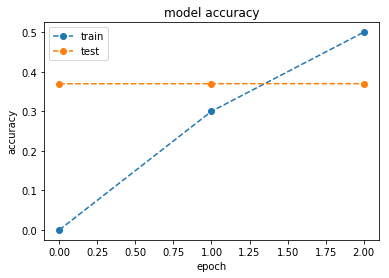

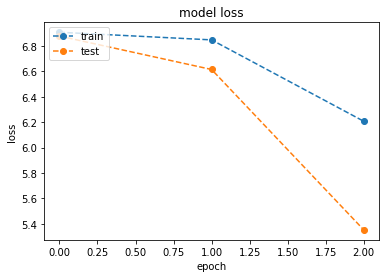

In [38]:
_, his = train(epoch=3, batch_size=10, data_limit=10)
plot_training_history(his)

In [ ]:
val(model_weights_filename="data/ckpts/trained_model_weights.h5")

Creating Model...
Creating image model...
Creating text model...
Merging final model...
Loading Weights...


/Users/jennifervilla/Documents/tensorflow_python3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  


Evaluating Accuracy on validation set:
   480/121512 [..............................] - ETA: 14:53

## Migrating to a Functional-Style Keras Model
### Merge Layer Deprecation
When we ran the initial model, we saw warnings that as of Keras 2.0, the Merge layer used in `vqa_model()` has been deprecated. The suggested fix would be to instead use a Multiply layer to perform the elementwise multiplication, but the Multiply layer will only accept tensors. Several workarounds were tried, including using the new Multiply layer with "vgg_model.output" and "lstm_model.output", but we ran into issues there because we were using "symbolic tensors" rather than actual tensors. 

The proper approach, recommended by the Keras development community, is to switch from sequential style models, heavily utilized in Keras 1.0, to functional models, recommanded de-facto for Keras 2.0. Hence, we have redefined our models in functional Keras syntax.

In [47]:
from keras.models import Sequential, Model

In [48]:
def img_model(dropout_rate):
    print("Creating functional image model...")
    input_img = Input((4096,))
    img_embedding = Dense(1024, input_dim=4096, activation='tanh')(input_img)
    return input_img, img_embedding

In [49]:
def Word2VecModel(embedding_matrix, num_words, embedding_dim, seq_length, dropout_rate):
    print("Creating functional text model...")
    input_q = Input((seq_length,))
    x = Embedding(num_words, embedding_dim, weights=[embedding_matrix], trainable=False)(input_q)
    x = LSTM(units=512, return_sequences=True)(x)
    x = Dropout(dropout_rate)(x)
    x = LSTM(units=512, return_sequences=False)(x)
    x = Dropout(dropout_rate)(x)
    q_embedding = Dense(1024, activation='tanh')(x)
    return input_q, q_embedding

In [50]:
def vqa_model(embedding_matrix, num_words, embedding_dim, seq_length, dropout_rate, num_classes):
    input_img, img_embedding = img_model(dropout_rate)
    input_q, q_embedding = Word2VecModel(embedding_matrix, num_words, embedding_dim, seq_length, dropout_rate)
    print("Merging final functional model...")
    combined = Multiply()([img_embedding, q_embedding])
    combined = Dropout(dropout_rate)(combined)
    combined = Dense(1000, activation='tanh')(combined)
    combined = Dropout(dropout_rate)(combined)
    predictions = Dense(num_classes, activation='softmax')(combined)
    fc_model = Model(inputs=[input_img, input_q], outputs=predictions)
    fc_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return fc_model

Refactoring to functional style models breaks the ability to load the pre-trained weights, which were trained on the sequential model definition.

Therefore, to validate our functional model implementation, we trained the model from scratch overnight, and recorded evaluation results against the validation set at every 10 epochs. Keras has support to evaluate the validation set, but only for every single epoch, so we wrote our own function instead.  We also printed out a heartbeat as the training continued.


Reading Data...
Creating Model...
Creating functional image model...
Creating functional text model...
Merging final functional model...
No model weights file specified. Skipping weight load.
Train on 10 samples, validate on 121512 samples
Epoch 1/4
Epoch 00000: saving model to data/ckpts/trained_model_weights.h5
10/10 [==============================] - 192s - loss: 6.9082 - acc: 0.0000e+00 - val_loss: 6.8785 - val_acc: 0.3698
Epoch 2/4
Epoch 00001: saving model to data/ckpts/trained_model_weights.h5
10/10 [==============================] - 193s - loss: 6.8451 - acc: 0.5000 - val_loss: 6.6187 - val_acc: 0.3699
Epoch 3/4
Epoch 00002: saving model to data/ckpts/trained_model_weights.h5
10/10 [==============================] - 192s - loss: 6.1953 - acc: 0.6000 - val_loss: 5.4405 - val_acc: 0.3699
Epoch 4/4
Epoch 00003: saving model to data/ckpts/trained_model_weights.h5
10/10 [==============================] - 190s - loss: 3.8275 - acc: 0.5000 - val_loss: 5.5295 - val_acc: 0.3699


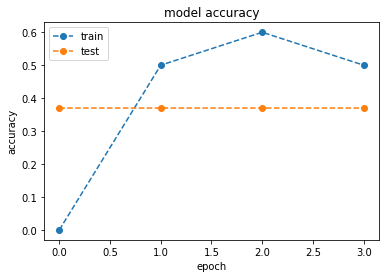

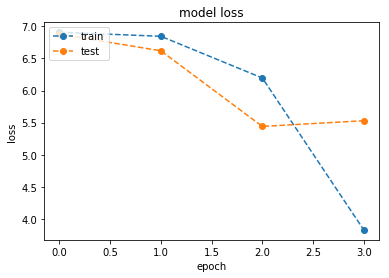

In [51]:
_, his = train(epoch=4, batch_size=10, data_limit=10)
plot_training_history(his)

In [14]:
def loop(num_loops, epoch, batch_size, data_limit):
    wfilename = ckpt_model_weights_filename
    
    for i in range(1, num_loops + 1):
        #First time through, do not preload weights
        if i == 1:
            model, _ = train(epoch, batch_size, data_limit, "")
        
        #Second time through, preload weights from prior training
        else:    
            model, _ = train(epoch, batch_size, data_limit, wfilename)
        
        #Evaluate model on the most recent weight values
        metrics, true_positive_rate = val(wfilename)
        with open("training_log", "a") as val_log:
            val_log.write("After training epoch " + str(epoch * i)+"\n")
            for name, value in metrics:
                val_log.write(name + " " + str(value)+"\n")
            val_log.write("True_positive_rate: " + str(true_positive_rate)+"\n")
        print("Finished loop number: ", i)
    
    print("Full training complete!")

Here we run the loop function to test it. Again, we keep all parameters small in order to run quickly. 

In [19]:
loop(num_loops=2, epoch=2, batch_size=10, data_limit=10)

Reading Data...
Creating Model...
Creating functional image model...
Creating functional text model...
Merging final model...
No model weights file specified. Skipping weight load.
Epoch 1/2
Epoch 00001: saving model to data/ckpts/trained_model_weights.h5
10/10 [==============================] - 3s 332ms/step - loss: 6.9080 - acc: 0.0000e+00
Epoch 2/2
Epoch 00002: saving model to data/ckpts/trained_model_weights.h5
10/10 [==============================] - 1s 77ms/step - loss: 6.8338 - acc: 0.5000
Creating Model...
Creating functional image model...
Creating functional text model...
Merging final model...
Loading Weights...
Evaluating Accuracy on validation set:
   544/121512 [..............................] - ETA: 24:12

KeyboardInterrupt: 

Upon running the `loop` function on the full dataset for 100 epochs, our results were as follows: <br>

|  Epoch        | Accuracy            | True Postitve Rate   | Loss
| :-------------: |:-------------| :-----|:-----|
| 10     | 0.445552702614 | 0.573844558562 |2.53969596104|
| 20      | 0.454802817829      |   0.58548949898 |2.59171895231|
| 30 |         0.45152742116|0.582181183751  |2.6666429342|
|40|0.458144051616|  0.587061360195 |2.76133057947
|50 |0.453848179604 |0.581045493449| 2.9734828312
|60 |0.449074988479 |0.577926459938 |3.08288818925
|70 |0.450976035289 |0.577959378498 |3.19416170537
|80 |0.449881493186 |0.577910000658 |3.32517784668
|90 | 0.445272894858| 0.572231549147 |3.3803069139
|100 |0.44325663309 |0.571375666601|3.44215128993

Here, **Accuracy** measures the rate at which the predicted answer is the same as the top human answer.

**True Positive Rate** measures the rate at which the predicted answer matches any one of the 10 human provided answers.

**Loss** measures the categorical cross-entropy on the validation set.

After training 30 epochs, our functional model achieved an accuracy on the validation set of 45.15%, which is almost identical to the 45.03% accuracy figure reported by the original implementers of the sequential model. We believe the differences between our accuracies are caused by using difference batch_sizes. 

Our model achieved highest accuracy after 40 epochs, with an accuracy of 45.81%. After 40 epochs, both the accuracy and true positive rate declines, indicating overfitting of the model.

## Next Steps
1. **Test different image embeddings**: Currently, our model uses image embeddings taken from the last hidden layer of VGG19. We would like to test the performance of embeddings taken from other well-known CNN models. Keras has [open source implementations](https://github.com/fchollet/keras/tree/master/keras/applications) of Resnet-50, Inception-Resnet_v2, Inception_v3, and Xception. A search of Github also reveals a Keras [Resnet-152](https://gist.github.com/flyyufelix/7e2eafb149f72f4d38dd661882c554a6) implementation, which might also be worth trying since this was the [model](https://web.stanford.edu/class/cs224n/reports/2748290.pdf) used by another Stanford team. As with our existing model, it probably makes sense to pre-compute the image features by running the VQA dataset images through the chosen network for embedding. Using our new set of image features, we can re-train our model to see if we can achieve better accuracy. 
2. **Implement New Cost Function for Soft Cross Entropy Loss**: Currently our model uses binary cross-entropy loss, with the ground-truth answer being a one-hot vector encoding the answer given by the majority of the human respondents polled. However, the VQA metric actually awards partial credit to models that output answers that match any of the ten human respondent answers. Thus, there is currently a disconnect between the loss function and the evaluation metric. One of the top performers in this year's VQA challenge sought to address this by proposing a [soft cross entropy loss](https://ilija139.github.io/pub/cvpr2017_vqa.pdf) function. This function calculates a weighted average of all unique ground truth answers given by the 10 human respondents. In the paper, these researchers achieved ~1.2-1.6% improved accuracy across a variety of model architectures. We would like to see if this improvement translates to our model as well. 
3. **Implement Multi-Modal Factorized Bilinear Pooling**: The [second place winner](https://arxiv.org/pdf/1708.01471.pdf) in this year’s VQA challenge proposed the concept of multi-modal factorized bilinear pooling. The idea is that using concatenation or elementwise multiplication to combine image and question embeddings (each of which represents information from a different modality, hence the term “multi-modal”) may limit model performance. A more sophisticated approach to fusing these two might be necessary. Thus they proposed “multi-modal factorized bilinear pooling”, which amounts to a combination of element-wise multiplication, fully connected layers, and sum pooling. We would like to see the impact of substituting this technique in place of our current “Multiply” layer in our VQA model. Once we implement co-attention (see $4$), we could also incorporate this technique into that model. (Authors of the original paper saw improvement in both simpler model architectures, such as the one we currently have, and those with co-attention).
4. **Implement Image-Question Co-attention**: All of the top performing VQA models use some form of attention. While early research focused exclusively on image attention [[1]](https://arxiv.org/abs/1511.07394), more recent work has combined image attention with question attention [[2]](https://arxiv.org/abs/1606.00061) [[3]](https://web.stanford.edu/class/cs224n/reports/2748290.pdf). The philosophy behind the latter approach is just as certain regions of the image are more relevant than others, certain words in the question are more helpful in answering than others. A variety of different co-attention architectures have been proposed, including hierarchical co-attention, which looks at question attention recursively on word, phrase, and full question levels. Other co-attention models (like [3]) include information indicating the part of speech of a word. We plan on starting with an architecture like the one proposed in the "Multi-Modal Factorized Bilinear Pooling" paper, which won second place [[4]](https://arxiv.org/pdf/1708.01471.pdf). The experimenters provide their [source code](https://github.com/yuzcccc/vqa-mfb), but it is written in Caffe. 


As observed in the [**Note**](#word_embedding_note), the word embeddings taken from the open source code we imported only used the last hidden state output of the LSTM (i.e. output from the second layer). Now we'll fix that and retrain to see if our accuracy is improved by using the cell ('c') and hidden ('h') output of both LSTM hidden layers. This is what the original [VQA paper](https://arxiv.org/pdf/1505.00468v6.pdf) describes doing. 

In [15]:
def Word2VecModel(embedding_matrix, num_words, embedding_dim, seq_length, dropout_rate):
    print("Creating functional text model with both layers...")
    input_q = Input((seq_length,))
    x = Embedding(num_words, embedding_dim, weights=[embedding_matrix], trainable=False)(input_q)
    lstm1, state_h1, state_c1 = LSTM(units=512, return_sequences=True, return_state=True)(x)
    #lstm1_d = Dropout(dropout_rate)(lstm1)
    
    lstm2, state_h2, state_c2 = LSTM(units=512, return_sequences=False, return_state=True)(lstm1)    
    #lstm2_d = Dropout(dropout_rate)(lstm2)
    
    #print("state_h1 state_c1 " + str(state_h1.get_shape()) + " " + str(state_c1.get_shape()))
    #print("state_h2 state_c2 " + str(state_h2.get_shape()) + " " + str(state_c2.get_shape()))
    
    concat = Concatenate()([state_h1, state_c1, state_h2, state_c2])
    #print("concat shape: " + str(concat.get_shape()) )
    
    q_embedding = Dense(1024, activation='tanh')(concat)
    #print("q_embedding: " + str(q_embedding.get_shape()) )
    
    return input_q, q_embedding

In [25]:
train(2, 10, 20, "data/model_weights_paper.h5")

Reading Data...
Creating Model...
Creating functional image model...
Creating functional text model with both layers...
Merging final functional model...
Could not find file: data/model_weights_paper.h5 for loading. Skipping weight load.
Epoch 1/2
20/20 [==============================] - 0s - loss: 6.8382 - acc: 0.0500         
Epoch 2/2
20/20 [==============================] - 0s - loss: 4.1239 - acc: 0.3000     
